In [6]:
%matplotlib inline

import gym
import itertools
import numpy as np
import os
import random
import sys
import tensorflow as tf
import math
if "../" not in sys.path:
  sys.path.append("../")

from lib import plotting
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [7]:
env = gym.envs.make("CartPole-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [8]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [25]:
class Estimator():
    """
    Q-Value Estimator neural network.

    This network is used for both the Q-Network and the Target Network.
    """

    def __init__(self, sess ,state_dim, action_space, scope="estimator", summaries_dir='./', deulling=False):
        """
        Builds the Tensorflow graph.
        """
        self.summary_writer = None
        
        with tf.variable_scope(scope):
            self.scope = scope
            # Placeholders for our input
            self.X_pl = tf.placeholder(shape=(None, state_dim), dtype=tf.float32, name="X")
            # The TD target value
            self.y_pl = tf.placeholder(shape=(None,), dtype=tf.float32, name="y")
            
            self.actions_pl = tf.placeholder(shape=(None,), dtype=tf.int32, name="act")
            
            batch_size = tf.shape(self.X_pl)[0]
            
            with tf.name_scope('fcl1'):
                self.fcl1 = tf.layers.dense( self.X_pl, 128, activation=tf.nn.relu, name='fcl1')
                  
            with tf.name_scope('fcl2'):
                self.fcl2 = tf.layers.dense( self.fcl1, 128, activation=tf.nn.relu )

            with tf.name_scope('fcl3'):
                self.predictions = tf.layers.dense( self.fcl2, action_space )

            self.indices = tf.concat((tf.expand_dims(tf.range(batch_size), 1), tf.expand_dims(self.actions_pl, 1)), axis=1)
            self.state_action_predictions = tf.gather_nd(self.predictions, self.indices)
            
            # Calculate the loss
            with tf.name_scope('loss'):
                self.losses = tf.squared_difference(self.y_pl, self.state_action_predictions)
                self.loss = tf.reduce_mean(self.losses)

            # Optimizer and training
            with tf.name_scope('train'):
                self.optimizer = tf.train.AdamOptimizer()
                self.train_op = self.optimizer.minimize(self.loss, global_step=tf.contrib.framework.get_global_step())

            tf.summary.scalar('loss', self.loss)
            
            # Summaries for Tensorboard
            self.summaries = tf.summary.merge([
                tf.summary.scalar("loss", self.loss),
                tf.summary.histogram("loss_hist", self.losses),
                tf.summary.histogram("q_values_hist", self.predictions),
                tf.summary.scalar("max_q_value", tf.reduce_max(self.predictions))
            ])
            
            summary_dir = os.path.join(summaries_dir, "summaries_{}".format(scope))
            if not os.path.exists(summary_dir):
                os.makedirs(summary_dir)
            self.summary_writer = tf.summary.FileWriter(summary_dir)
            self.summary_writer.add_graph(sess.graph)

    def get_td_error(self, sess, s, a, y):
        feed_dict = { self.X_pl: s, self.y_pl: y , self.actions_pl: a }
        return sess.run(self.td_error, feed_dict)
    
    def predict(self, sess, s):
        """
        Predicts action values.

        Args:
          sess: Tensorflow session
          s: State input of shape [batch_size, 4, 160, 160, 3]

        Returns:
          Tensor of shape [batch_size, NUM_VALID_ACTIONS] containing the estimated 
          action values.
        """
        return sess.run(self.predictions, { self.X_pl: s })

    def update(self, sess, s, a, y):
        """
        Updates the estimator towards the given targets.

        Args:
          sess: Tensorflow session object
          s: State input of shape [batch_size, 4, 160, 160, 3]
          a: Chosen actions of shape [batch_size]
          y: Targets of shape [batch_size]

        Returns:
          The calculated loss on the batch.
        """
        feed_dict = { self.X_pl: s, self.y_pl: y , self.actions_pl: a}
        summaries, global_step, loss,  _ = sess.run(
            [self.summaries, tf.contrib.framework.get_global_step(), self.loss, self.train_op],
            feed_dict)
        if self.summary_writer:
            self.summary_writer.add_summary(summaries, global_step)
        return loss

In [26]:
def copy_model_parameters(sess, estimator1, estimator2):
    """
    Copies the model parameters of one estimator to another.

    Args:
      sess: Tensorflow session instance
      estimator1: Estimator to copy the paramters from
      estimator2: Estimator to copy the parameters to
    """
    e1_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator1.scope)]
    e1_params = sorted(e1_params, key=lambda v: v.name)
    e2_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator2.scope)]
    e2_params = sorted(e2_params, key=lambda v: v.name)
    update_ops = []
    for e1_v, e2_v in zip(e1_params, e2_params):
        op = e2_v.assign(e1_v)
        update_ops.append(op)
    sess.run(update_ops)

In [27]:
def make_epsilon_greedy_policy(estimator, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.

    Args:
        estimator: An estimator that returns q values for a given state
        nA: Number of actions in the environment.

    Returns:
        A function that takes the (sess, observation, epsilon) as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.

    """
    def policy_fn(sess, observation, epsilon):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(sess, np.expand_dims(observation, 0))[0]
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [36]:
def deep_q_learning(sess,
                    env,
                    q_estimator,
                    target_estimator,
                    n_steps,
                    replay_memory_init_size=64,
                    epsilon_decay_size=1000,
                    replay_memory_size=10000,
                    update_target_estimator_every=100,
                    discount_factor=0.99,
                    batch_size=32):
    """
    Q-Learning algorithm for off-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.

    Args:
        sess: Tensorflow Session object
        env: OpenAI environment
        q_estimator: Estimator object used for the q values
        target_estimator: Estimator object used for the targets
        state_processor: A StateProcessor object
        num_episodes: Number of episodes to run for
        experiment_dir: Directory to save Tensorflow summaries in
        replay_memory_size: Size of the replay memory
        replay_memory_init_size: Number of random experiences to sampel when initializing 
          the reply memory.
        update_target_estimator_every: Copy parameters from the Q estimator to the 
          target estimator every N steps
        discount_factor: Gamma discount factor
        epsilon_start: Chance to sample a random action when taking an action.
          Epsilon is decayed over time and this is the start value
        epsilon_end: The final minimum value of epsilon after decaying is done
        epsilon_decay_steps: Number of steps to decay epsilon over
        batch_size: Size of batches to sample from the replay memory
        record_video_every: Record a video every N episodes

    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    # The replay memory
    replay_memory = []
    
    
    epsilon_start = 1.0
    epsilon_final = 0.01
    epsilon_decay = 1000

    epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

    epsilons = [epsilon_by_frame(i) for i in range(10000)]
    betas = np.linspace(0.4, 1.0, 1000)
    policy = make_epsilon_greedy_policy(q_estimator, env.action_space.n)

    
    done = True
    total_t = sess.run(tf.contrib.framework.get_global_step())
    
    losses = []
    for i in range(replay_memory_init_size):
        epsilon = epsilons[min(total_t, len(epsilons)-1)]
        if done: 
            state = env.reset()
            action = np.random.choice(range(env.action_space.n), p=policy(sess, state, epsilon))
        else:
            action = np.random.choice(range(env.action_space.n), p=policy(sess, state, epsilon))
            state = next_state
        next_state, reward, done, _ = env.step(action)
        replay_memory.append((state, action, reward, next_state, done))
        total_t += 1
        
    loss = None
    
    for step in range(n_steps):

        if done: 
            state = env.reset()
        
        epsilon = epsilons[min(total_t, len(epsilons)-1)]

        if total_t % update_target_estimator_every == 0:
            copy_model_parameters (sess ,q_estimator ,target_estimator)


        action = np.random.choice(range(env.action_space.n), p=policy(sess, state, epsilon))
        next_state, reward, done, _ = env.step(action)
        
        if len(replay_memory) == replay_memory_size:
            replay_memory.pop(0)
            
        replay_memory.append((state, action, reward, next_state, done))
        
        minibatch = replay_memory if len(replay_memory) < batch_size else random.sample(replay_memory, batch_size)
        
        minibatch_states, minibatch_actions, minibatch_rewards, minibatch_next_states, minibatch_dones = map(np.array, zip(*minibatch))
        
        max_Qs = np.max(target_estimator.predict(sess, minibatch_next_states), axis=1)
        targets = minibatch_rewards + (1 - minibatch_dones) * discount_factor * max_Qs

        # use loss and do backprop update on neural network estimator
        loss = q_estimator.update(sess, minibatch_states, minibatch_actions, targets)

        state = next_state
        total_t += 1

    return stats

In [39]:
import shutil
from datetime import datetime
now = datetime.now()

tf.reset_default_graph()

# shutil.rmtree('./experiments')
# shutil.rmtree('./experiments_target')

experiment_dir_q = os.path.abspath('./experiments')
experiment_dir_target = os.path.abspath('./experiments_target')

global_step = tf.Variable(0, name="global_step", trainable=False)


# Run it!
with tf.Session() as sess:
    # Create estimators
    q_estimator = Estimator(sess, env.observation_space.shape[0], env.action_space.n, scope='q_estimator', summaries_dir=experiment_dir_q, deulling=True)
    target_estimator = Estimator(sess, env.observation_space.shape[0], env.action_space.n, scope='target_estimator', summaries_dir=experiment_dir_target, deulling=True)
    sess.run(tf.initialize_all_variables())
    deep_q_learning(sess,
                        env,
                        q_estimator=q_estimator,
                        target_estimator=target_estimator,
                        n_steps=10000,
                        replay_memory_size=1000,
                        replay_memory_init_size=64,
                        update_target_estimator_every=100,
                        discount_factor=0.99,
                        batch_size=32)
        #pass


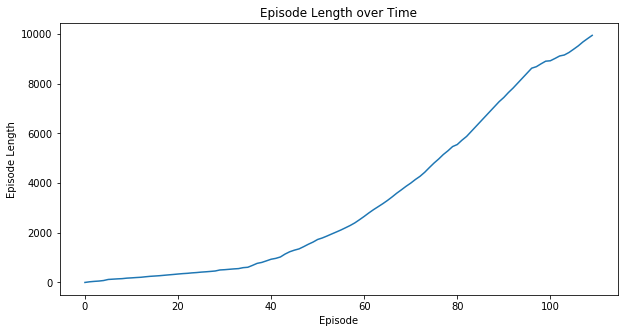

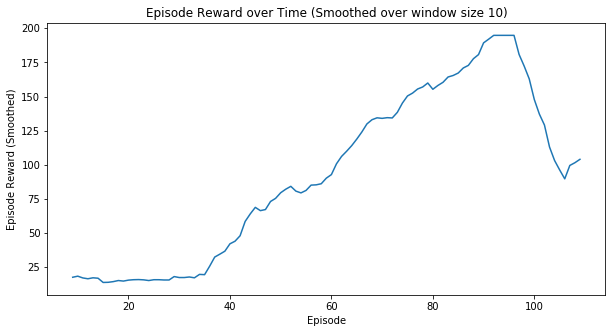

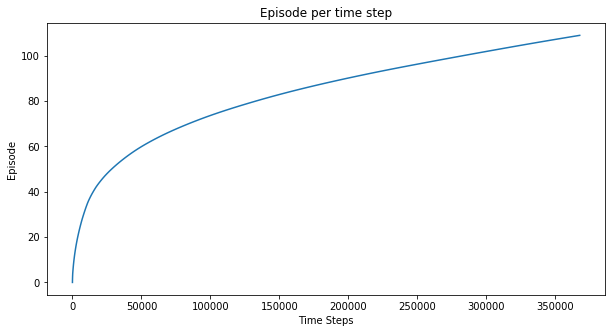

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [34]:
plotting.plot_episode_stats(stats)